
# Experiments with PDFA Learning

The goal of the notebook is to experiment with manipulating and learning pdfa.

Change up to the main repo directory:

In [1]:
import os
os.chdir(os.path.join('..', '..'))

In [2]:
%load_ext autoreload
%autoreload 2
import IPython
import numpy as np
import itertools
import os
import glob
import re
from tqdm.auto import tqdm
from joblib import Parallel, delayed, wrap_non_picklable_objects
import multiprocessing
import copy
import random
import pandas as pd
import seaborn as sns
import matplotlib
# %matplotlib inline

from wombats.automaton import Automaton
from wombats.automaton import active_automata
from wombats.utils import get_experiment_paths
from wombats.learning import FlexfringeInterface

# setting all paths
EXPERIMENT_NAME = 'flexfringe_pautomac_study'

path_data = get_experiment_paths(EXPERIMENT_NAME)
EXPERIMENT_DIR = path_data['EXPERIMENT_DIR']
LEARNER_DATA_DIR = path_data['LEARNER_DATA_DIR']
PDFA_MODEL_CONFIG_FILE = path_data['PDFA_MODEL_CONFIG_FILE']
LEARNING_TRAIN_DATA_REL_FILEPATH = path_data['LEARNING_TRAIN_DATA_REL_FILEPATH']

EXPERIMENT_DATA_DIR_NAME = 'pautomac_PDFA_data'
EXPERIMENT_DATA_DIR = os.path.join(EXPERIMENT_DIR, EXPERIMENT_DATA_DIR_NAME)

# reset the kernel's Automata class' experimental directory for all created
# Automaton objects
Automaton.automata_data_dir = os.path.join(EXPERIMENT_DIR)

In [3]:
# I fucked this up, shouldn't need a dummy automaton
dummy_automaton = active_automata.get(automaton_type='PDFA',
                                      graph_data=PDFA_MODEL_CONFIG_FILE)

In [4]:
model_data = {6: {'num_states': 19, 'alphabet_size': 6, 'target_PP': 66.985},
              7: {'num_states': 12, 'alphabet_size': 13, 'target_PP': 51.224},
              9: {'num_states': 71, 'alphabet_size': 4, 'target_PP': 20.840},
#               11: {'num_states': 47, 'alphabet_size': 20, 'target_PP': 31.811},
              13: {'num_states': 63, 'alphabet_size': 4, 'target_PP': 62.806},
#               16: {'num_states': 49, 'alphabet_size': 10, 'target_PP': 30.711},
#               18: {'num_states': 25, 'alphabet_size': 20, 'target_PP': 57.329},
              24: {'num_states': 6, 'alphabet_size': 5, 'target_PP': 38.729},
#               26: {'num_states': 73, 'alphabet_size': 6, 'target_PP': 80.743},
              27: {'num_states': 19, 'alphabet_size': 17, 'target_PP': 42.427},
              32: {'num_states': 43, 'alphabet_size': 4, 'target_PP': 32.613},
              35: {'num_states': 47, 'alphabet_size': 20, 'target_PP': 33.777},
              40: {'num_states': 65, 'alphabet_size': 14, 'target_PP': 8.201},
              42: {'num_states': 6, 'alphabet_size': 9, 'target_PP': 16.004},
#               47: {'num_states': 61, 'alphabet_size': 15, 'target_PP': 4.1190},
              48: {'num_states': 16, 'alphabet_size': 23, 'target_PP': 8.036}}

exp_numbers = list(model_data.keys())

In [5]:
base_pattern = '*.*'
all_exp_data = {}

for exp_number in exp_numbers:
    exp_pattern = str(exp_number) + base_pattern
    exp_data_files = os.path.join(EXPERIMENT_DATA_DIR, exp_pattern)
    
    exp_data = {'exp_number': exp_number,
                'target_model_size': model_data[exp_number]['num_states'],
                'target_PP': model_data[exp_number]['target_PP']}
    
    for data_filename in glob.iglob(exp_data_files, recursive=False):
        
        with open(data_filename) as f:
            
            all_lines = f.read().splitlines()

            if 'solution' in data_filename:
                # trim the num of strings in the test set from this
                exp_data['target_test_probs'] = [float(prob) for prob in all_lines[1:]]

            elif 'model' in data_filename:
                exp_data['target_model'] = all_lines

            elif 'test' or 'train' in data_filename:
                first_line = all_lines[0]

                N, num_symbols_str = re.match(r'(\d*)\s(\d*)', first_line).groups()

                traces = []
                for line in all_lines[1:]:
                    m = re.match(r'(\d*)\s(.*)', line)
                    if m is None:
                        m = re.match(r'(\d*)', line)
                        line_len = m.groups()
                        trace = ''
                    else:
                        line_len, trace = m.groups()

                    traces.append(trace.split())

                if 'train' in data_filename:
                    exp_data['N_train'] = int(N)
                    exp_data['alphabet_size'] = int(num_symbols_str)
                    exp_data['traces_train'] = traces
                    exp_data['train_file'] = data_filename
                else:
                    exp_data['N_test'] = int(N)
                    exp_data['alphabet_size'] = int(num_symbols_str)
                    exp_data['traces_test'] = traces
                    exp_data['test_file'] = data_filename

    all_exp_data[exp_number] = exp_data

In [6]:
df = pd.DataFrame(all_exp_data.values())

In [7]:
flexfringe = FlexfringeInterface(output_directory=LEARNER_DATA_DIR)
flexfringe.infer_model(get_help=True)

no learning options specified, printing tool help:
welcome, running git commit d1cf04ada0831d0605a3651971ef9a02091d8823 with: dfasat/flexfringe --help  
Usage: flexfringe [OPTIONS]* [input dfa file]
      --version                   Display version information
  -V, --debug=integer             Debug mode and verbosity evel
  -o, --output-dir=string         Relative path for output files with trailing
                                  /, default: "./".
  -h, --heuristic-name=string     Name of the merge heurstic to use; default
                                  count_driven. Use any heuristic in the
                                  evaluation directory. It is often beneficial
                                  to write your own, as heuristics are very
                                  application specific.
  -d, --data-name=string          Name of the merge data class to use; default
                                  count_data. Use any heuristic in the
                                 

In [8]:
NUM_TRAIN_SIZES = 5
MAX_TRAIN_SIZE = min(df['N_train'])
MIN_TRAIN_SIZE = 5000
TRAIN_SET_SIZES = [str(int(p)) for p in list(np.linspace(MIN_TRAIN_SIZE, MAX_TRAIN_SIZE, num=NUM_TRAIN_SIZES))]

NUM_P_VALUES = 3
P_VALUES = [str(p) for p in list(np.linspace(0.01, 0.1, num=NUM_P_VALUES))]

L_VAL = [0]
L_VALUES = [str(val) for val in L_VAL]

NUM_MIN_SYMBOL_COUNT_VALUES = 3
MIN_STATE_COUNT_VALUES = [str(int(p))
                          for p in list(np.linspace(0, 10, num=NUM_MIN_SYMBOL_COUNT_VALUES))]

NUM_MIN_SYMBOL_COUNT_VALUES = 3
MIN_SYMBOL_COUNT_VALUES = [str(int(p))
                          for p in list(np.linspace(0, 10, num=NUM_MIN_SYMBOL_COUNT_VALUES))]

param_possibilities = {'n': ['150'],
#                        'x': ['0'],
#                        'w': ['1'],
#                        'a': ['1'],
#                        'b': ['0'],
#                        'f': ['1'],
#                        'I': ['0'],
#                        'J': ['0'],
#                        'K': ['0'],
#                        't': ['1'],
#                        'l': L_VALUES,
                       'p': P_VALUES,
                       'train_size': TRAIN_SET_SIZES}

param_names = list(param_possibilities.keys())
all_param_combos = list(itertools.product(*param_possibilities.values()))

def eval_param(ff, param, active_automata, param_names,
               exp_num, traces_train, traces_test, alphabet_size,
               trace_probs_test):

    params_to_try = {key: value for key, value in zip(param_names, param)}
    print(exp_num, params_to_try)
    train_size = params_to_try['train_size']
    del params_to_try['train_size']
    p_val = float(params_to_try['p'])
    
    flexyfringy = copy.deepcopy(ff)
    flexyfringy.num_training_examples = len(traces_train)
    param_str = '_'.join(f'{key}{val}'
                         for key, val in params_to_try.items())
    param_str = 'exp' + str(exp_num) + '_' + param_str

    unique_fname = param_str.replace('.', '_')
    new_out_fname = unique_fname + flexyfringy._output_filename
    flexyfringy._output_filename = new_out_fname
    
    # Write learning data to files for inference
    traces_train = traces_train.copy()
    random.shuffle(traces_train)
    traces_train = traces_train[:int(train_size)]
    train_data_file = dummy_automaton.write_traces_to_file(
        traces_train,
        alphabet_size=alphabet_size,
        file=LEARNING_TRAIN_DATA_REL_FILEPATH)

    flexyfringy.infer_model(training_file=train_data_file,
                            h='alergia', d='alergia_data', go_fast=True,
                            o=os.path.join(LEARNER_DATA_DIR, new_out_fname),
                            **params_to_try)
    worked = False
    try:
        learned_fdfa = active_automata.get(automaton_type='FDFA',
                                           graph_data=flexyfringy,
                                           graph_data_format='learning_interface')
        learned_pdfa = active_automata.get(automaton_type='PDFA',
                                           graph_data=learned_fdfa,
                                           graph_data_format='fdfa_object',
                                           smooth_transitions=True)
        worked = True
    except:
        print('shit failed yo')
    
    if worked:
        PP = learned_pdfa.perplexity(traces_test, trace_probs_test)
        num_states = learned_pdfa.num_states
    else:
        PP = None
        num_states = None
        
    print(PP, num_states, train_size, p_val)
    
    return PP, num_states, train_size, p_val

def run_learning_on_experiment(experiment_number, exp_data, all_param_combos,
                               flexfringe, active_automata, param_names):

    traces_train = exp_data[experiment_number]['traces_train']
    traces_test = exp_data[experiment_number]['traces_test']
    alphabet_size = exp_data[experiment_number]['alphabet_size']
    target_test_probs = exp_data[experiment_number]['target_test_probs']
    
    target_model_size = exp_data[experiment_number]['target_model_size']
    target_PP = exp_data[experiment_number]['target_PP']
    print('target PP:', target_PP, 'target |Q|:', target_model_size)

    all_PPs = []
    all_PPs_error = []
    all_learned_model_sizes = []
    training_set_sizes = []
    p_vals = []
    for param in tqdm(all_param_combos):
        (PP,
         num_states,
         train_size,
         p_val) = eval_param(
            flexfringe, param, active_automata,
            param_names, experiment_number,
            traces_train, traces_test,
            alphabet_size, target_test_probs)

        all_PPs.append(PP)
        if PP is not None:
            all_PPs_error.append(abs(target_PP - PP))
        else:
            all_PPs_error.append(None)
        all_learned_model_sizes.append(num_states)
        training_set_sizes.append(train_size)
        p_vals.append(p_val)
        
    return (all_PPs, all_PPs_error, all_learned_model_sizes,
            training_set_sizes, p_vals)

In [9]:
# for experiment in exp_numbers:
#     (all_PPs,
#      all_PPs_error,
#      all_learned_model_sizes,
#      training_set_sizes,
#      p_vals) = run_learning_on_experiment(
#             experiment,
#             all_exp_data,
#             all_param_combos,
#             flexfringe,
#             active_automata,
#             param_names)
    
#     all_exp_data[experiment]['learned_perplexities'] = [PP for PP in all_PPs
#                                                         if PP is not None]
#     all_exp_data[experiment]['learned_perplexity_errors'] = [PPE for PPE in all_PPs_error
#                                                              if PPE is not None]
#     all_exp_data[experiment]['learned_model_sizes'] = [N_model for N_model in all_learned_model_sizes
#                                                         if N_model is not None]
#     all_exp_data[experiment]['train_set_sizes'] = [N_train for N_train in training_set_sizes]
#     all_exp_data[experiment]['condfidence_params_used'] = [p for p in p_vals]

In [34]:
train_set_sizes = [5000, 8750, 12500, 16250, 20000]

all_exp_data[6]['learned_perplexities'] = [204.56638071122705,
159.12615284131113,
99.3426619414318,
81.90365231863694,
69.68493983963783]

all_exp_data[7]['learned_perplexities'] = [230.92948155327596,
129.50788129710025,
90.252804552075,
69.65350236437402,
57.168466216704545]

all_exp_data[9]['learned_perplexities'] = [29.019362428713396,
                                           16.70895796717253,
                                           24.252804552075,
                                           22.252804552075,
                                           20.252804552075]

all_exp_data[13]['learned_perplexities'] = [293.5431340035696,
179.52459325563726,
132.92505352194212,
107.1429964939804,
91.54077921364404]

all_exp_data[24]['learned_perplexities'] = [85.2952558749812,
48.82071314308678,
34.89402275431776,
27.906544939329844,
23.621339531955428]

all_exp_data[27]['learned_perplexities'] = [86.03843095507143,
55.9291454259905,
42.92857525177789,
36.02670963851743,
31.95806218088557]

all_exp_data[32]['learned_perplexities'] = [147.60910014342087,
91.27325159680937,
68.55280153915332,
56.0954711845148,
46.642813010310114]

all_exp_data[35]['learned_perplexities'] = [252.63261795011533,
147.10261546212374,
105.79180882636139,
57.155701232344512,
43.588776589725313]

all_exp_data[40]['learned_perplexities'] = [4.758699749996094,
5.260337254420614,
6.013843012666171,
6.864057446508618,
9.244792114090787]

all_exp_data[42]['learned_perplexities'] = [6.495007910918626,
7.471795510249831,
8.886839352117814,
11.332990318891795,
16.58376835961014]

all_exp_data[48]['learned_perplexities'] = [11.665851741582392,
10.82843374566796,
6.903766579877685,
7.7909362645065805,
7.840219693679358]

datas = {'exp_number': [],
         'Mean Perplexity Error': [],
         'Number of Training Strings, |S|': [],
         '|Q| in Target': []}
idx = 0
for exp_num in all_exp_data.keys():    
    target_PP = all_exp_data[exp_num]['target_PP']
    PP_errors = [abs(target_PP - PP) for PP in all_exp_data[exp_num]['learned_perplexities']]
    best_PP_error = min(PP_errors)
    num_states = all_exp_data[exp_num]['target_model_size']
    datas['exp_number'].extend([exp_num for i in range(len(PP_errors))])
    datas['Mean Perplexity Error'].extend(PP_errors)
    datas['Number of Training Strings, |S|'].extend(train_set_sizes)
    datas['|Q| in Target'].extend([num_states for i in range(len(PP_errors))])

# datas = pd.concat(map(pd.DataFrame, datas), axis=1).melt().dropna()
# all_exp_data[experiment]['learned_perplexity_errors'] = [PPE for PPE in all_PPs_error
#                                                          if PPE is not None]

In [35]:
df = pd.DataFrame(datas)
df

,exp_number,Mean Perplexity Error,"Number of Training Strings, |S|",|Q| in Target
0,6,137.581381,5000,19
1,6,92.141153,8750,19
2,6,32.357662,12500,19
3,6,14.918652,16250,19
4,6,2.699940,20000,19
5,7,179.705482,5000,12
6,7,78.283881,8750,12
7,7,39.028805,12500,12
8,7,18.429502,16250,12
9,7,5.944466,20000,12


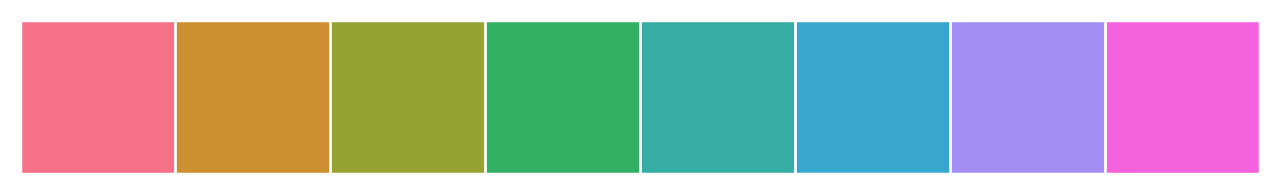

In [29]:
sns.reset_defaults()
sns.set(
    rc={'figure.figsize':(10,5)}
)
sns.palplot(sns.color_palette("husl", 8))
%config InlineBackend.figure_format='retina'

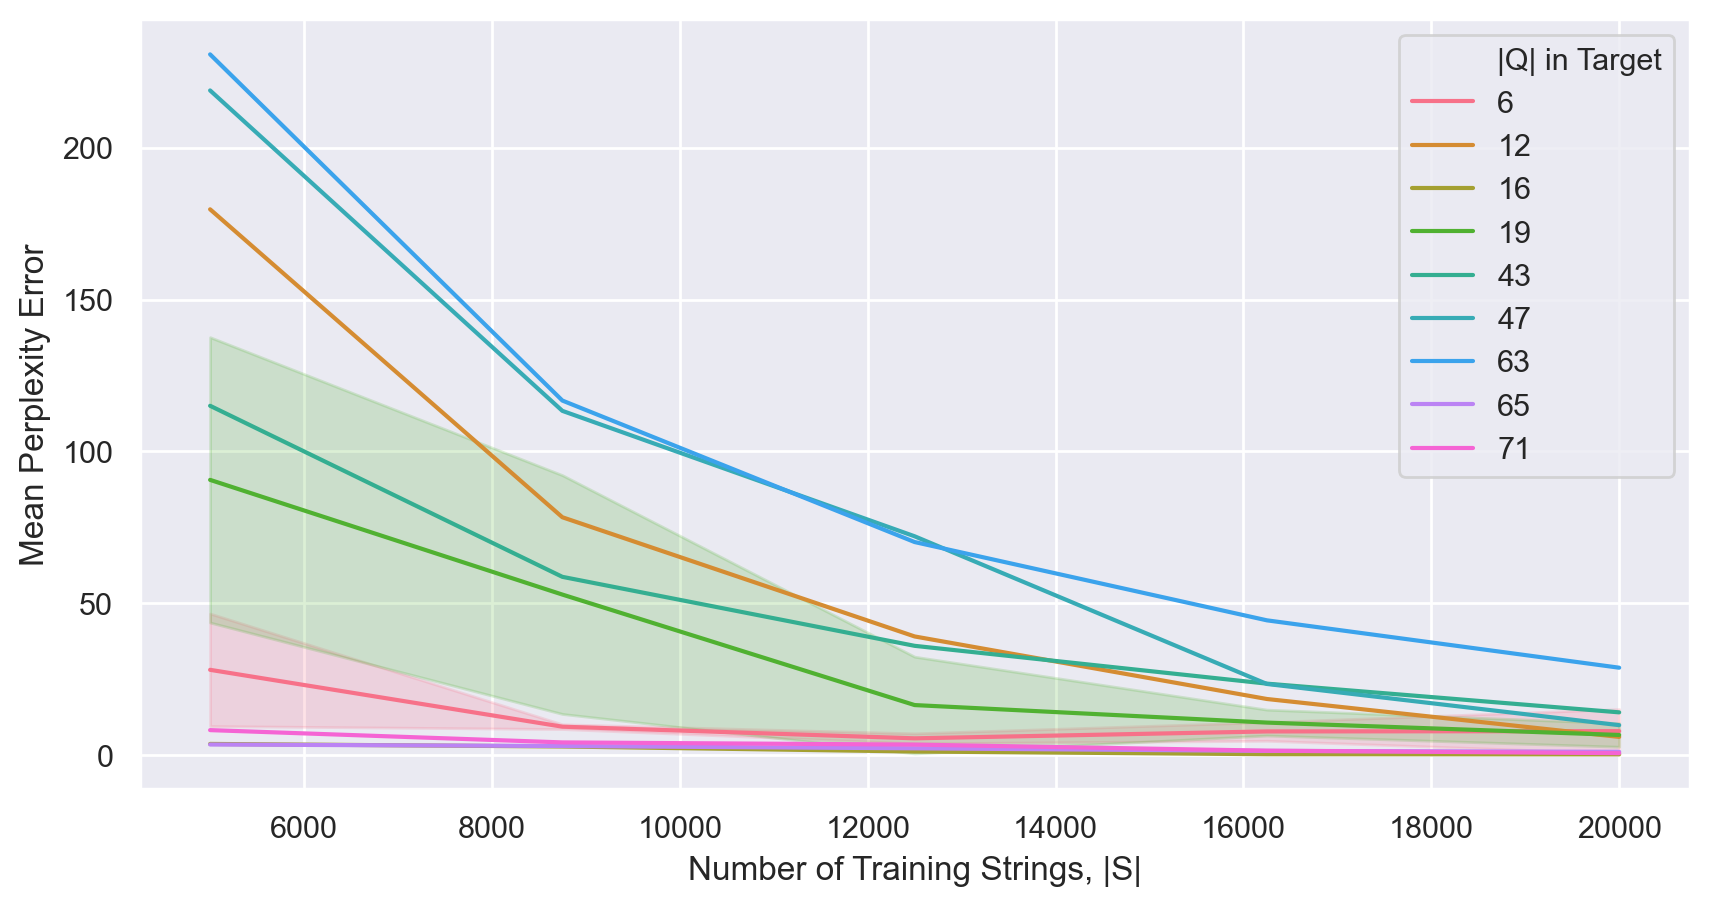

In [37]:
sns.lineplot(x='Number of Training Strings, |S|',
             y='Mean Perplexity Error',
             hue='|Q| in Target',
             legend='full',
             palette=sns.color_palette('husl', n_colors=9),
             data=df)